<a href="https://colab.research.google.com/github/tramgo/Temp/blob/main/Bodalchem1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fetching data...


[*********************100%***********************]  1 of 1 completed


Downloaded data shape: (747, 6)
Price                        Adj Close        Close         High          Low  \
Ticker                    BODALCHEM.NS BODALCHEM.NS BODALCHEM.NS BODALCHEM.NS   
Date                                                                            
2020-01-01 00:00:00+00:00    70.725632    72.650002    74.400002    70.800003   
2020-01-02 00:00:00+00:00    71.601791    73.550003    76.150002    71.800003   
2020-01-03 00:00:00+00:00    70.190193    72.099998    74.599998    68.949997   
2020-01-06 00:00:00+00:00    66.977608    68.800003    72.750000    68.050003   
2020-01-07 00:00:00+00:00    67.999794    69.849998    72.800003    68.849998   

Price                             Open       Volume  
Ticker                    BODALCHEM.NS BODALCHEM.NS  
Date                                                 
2020-01-01 00:00:00+00:00    73.949997       690399  
2020-01-02 00:00:00+00:00    72.800003       760610  
2020-01-03 00:00:00+00:00    73.800003       3123

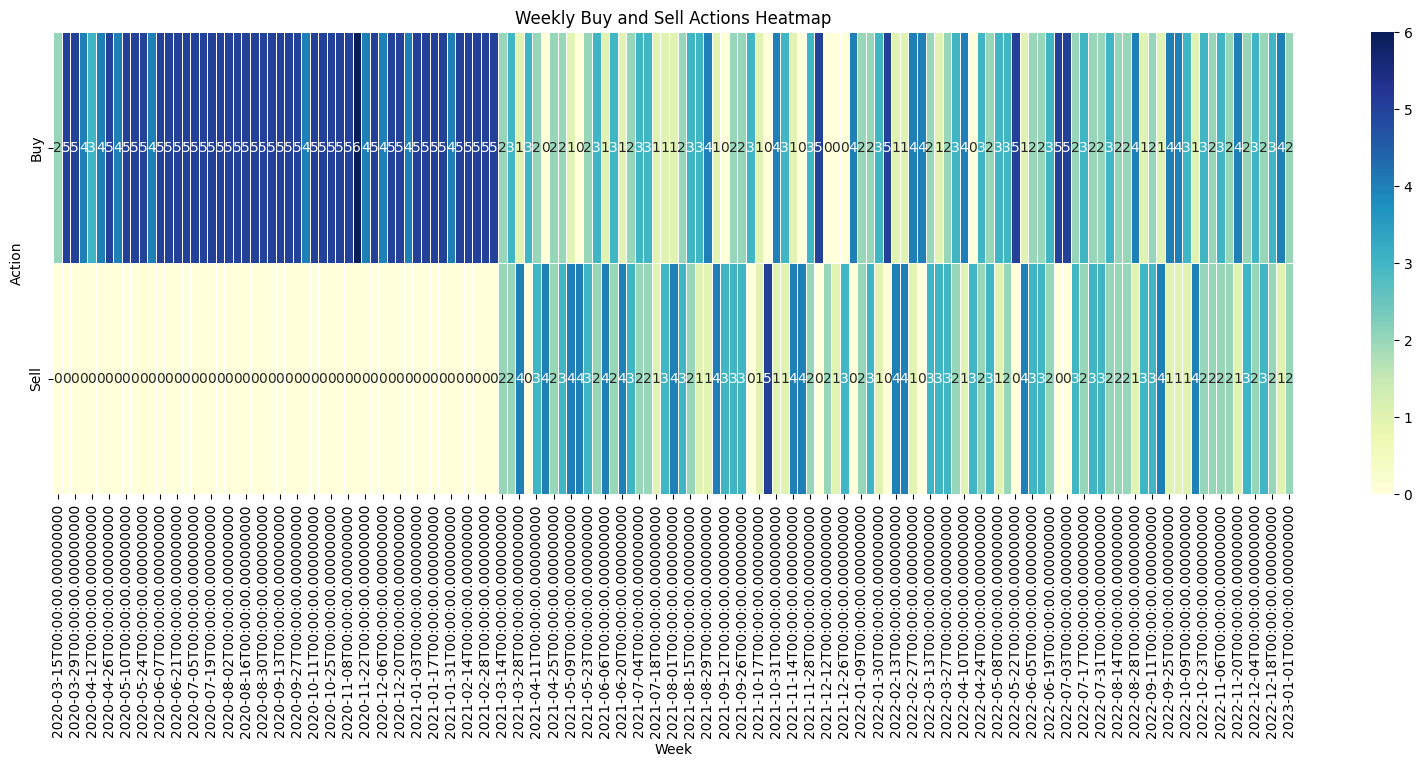

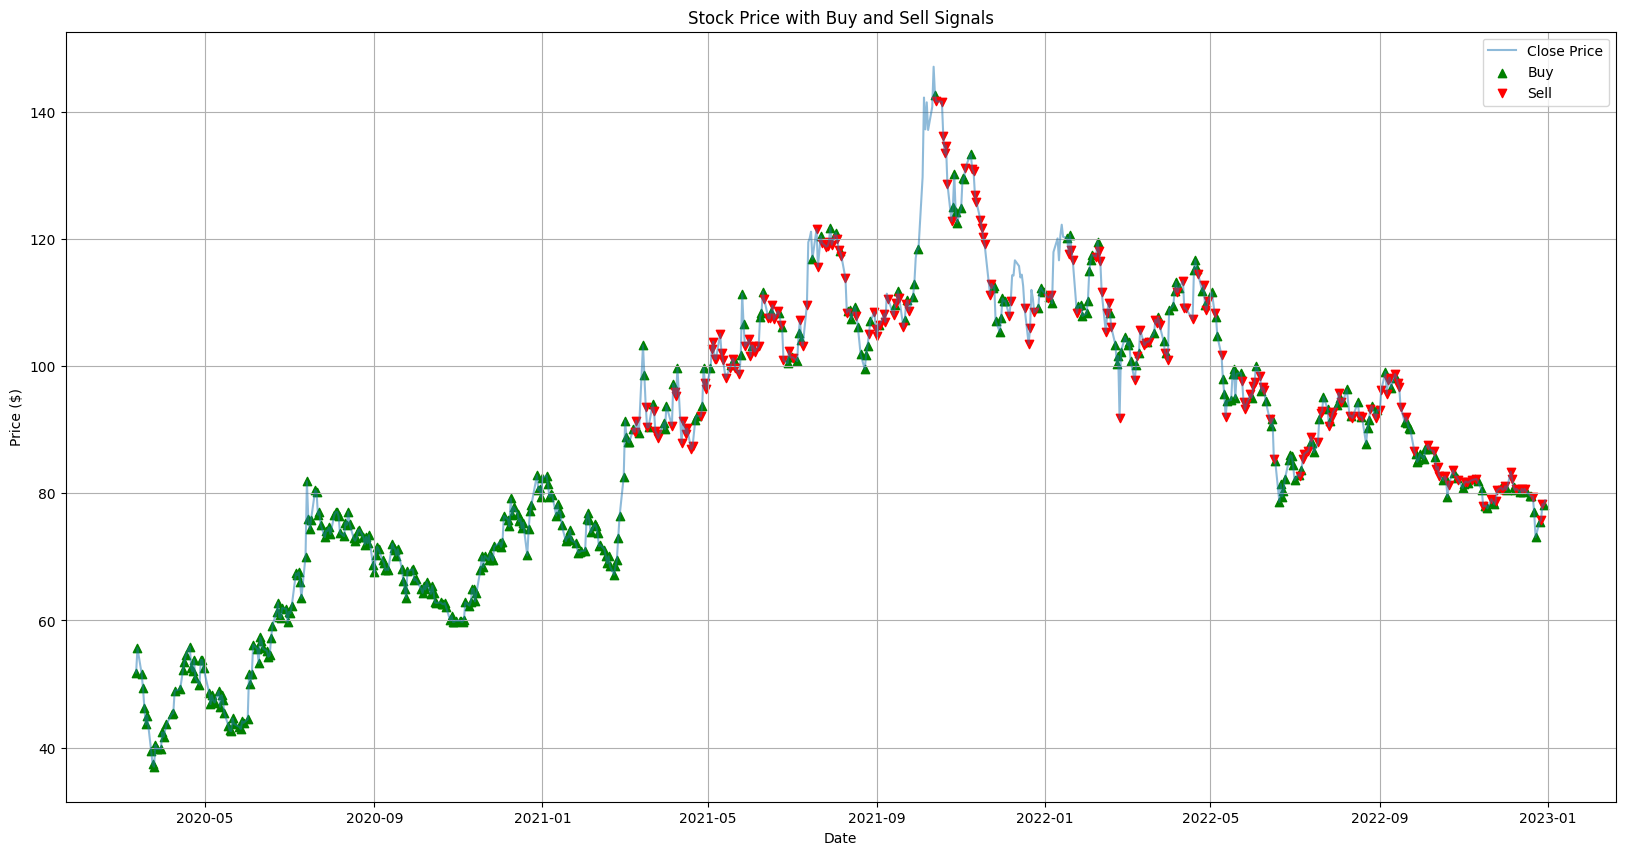

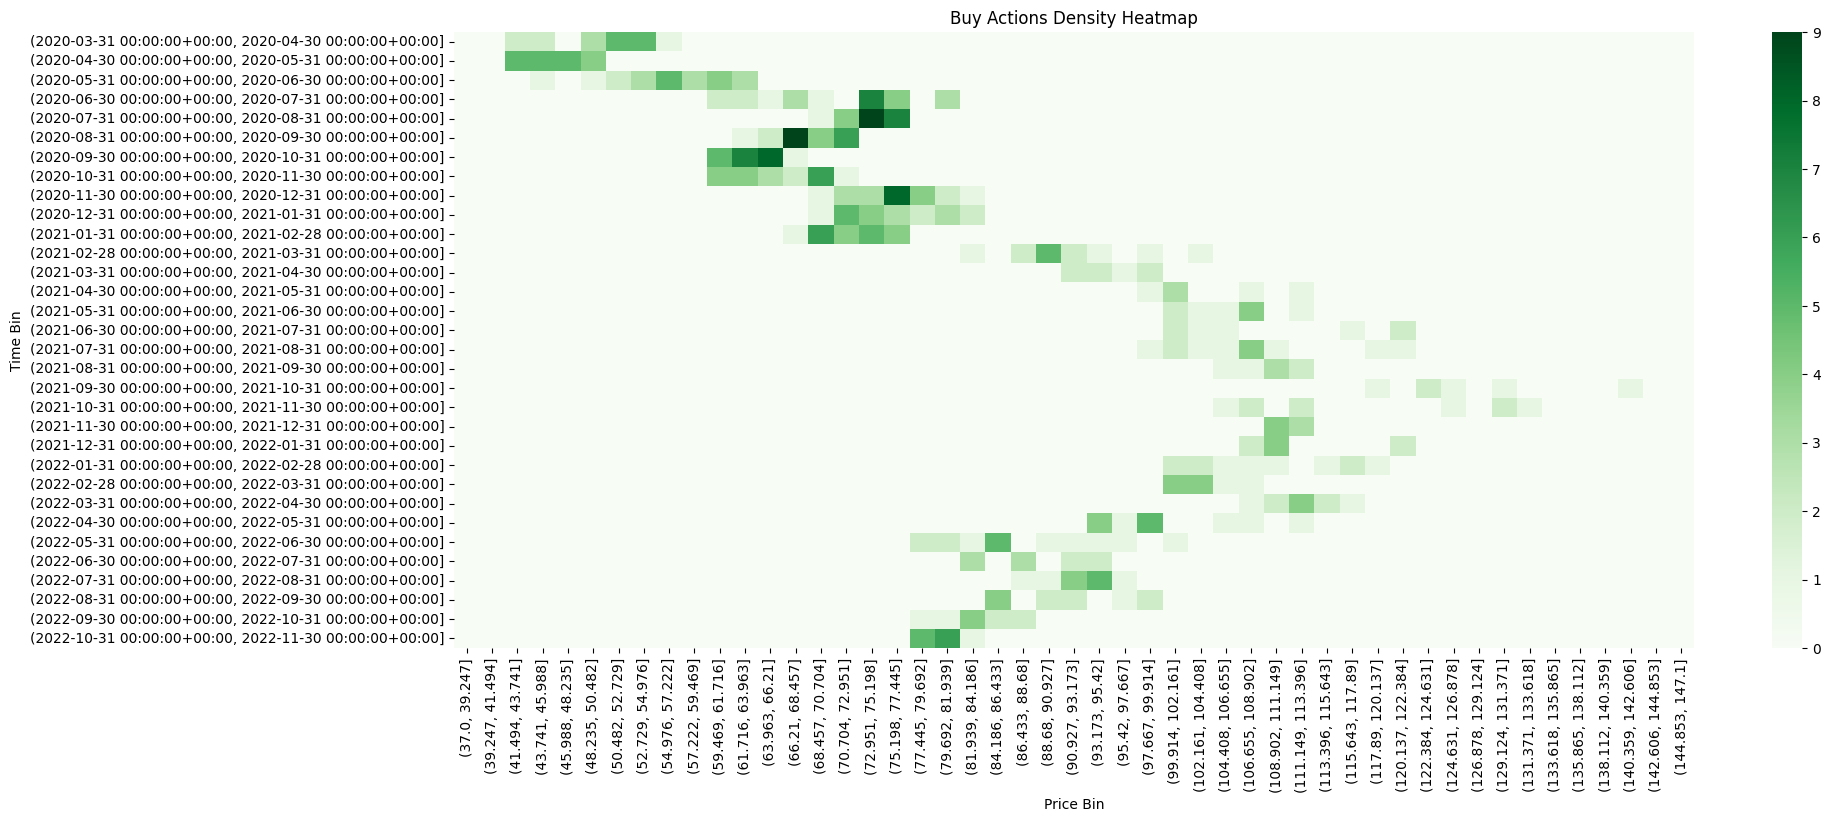

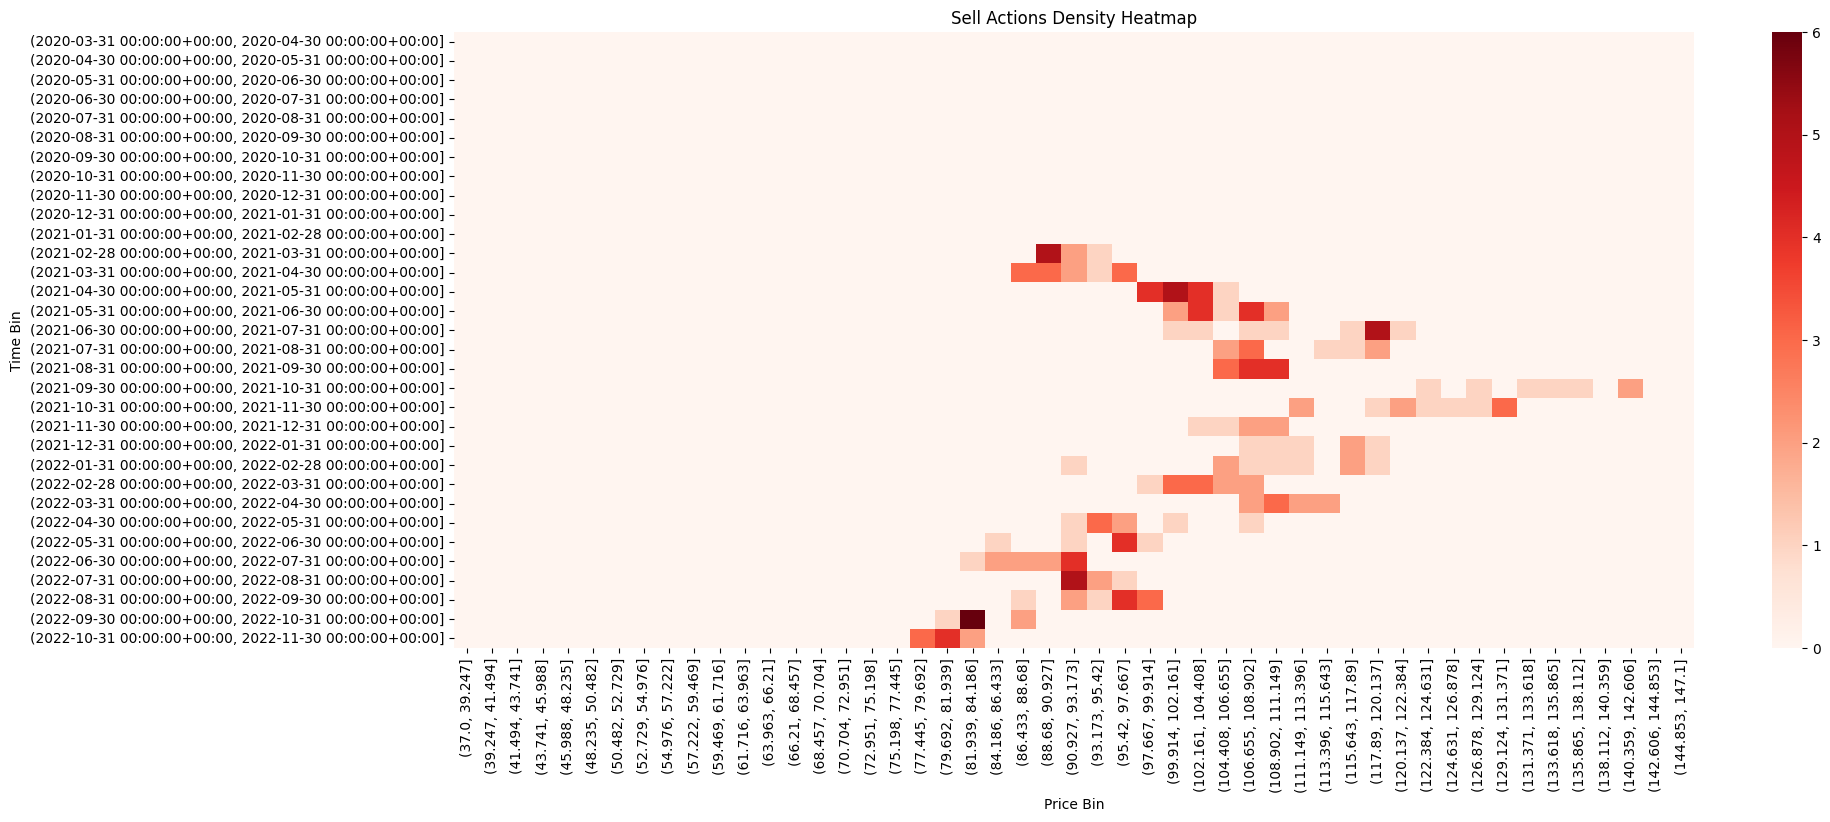


Strategy Performance:
Buy and Hold:
  Initial Balance: $10000
  Final Net Worth: $15230.30
  Profit: $5230.30

Moving Average Crossover with RSI:
  Initial Balance: $10000
  Final Net Worth: $10000.00
  Profit: $0.00

MACD Crossover:
  Initial Balance: $10000
  Final Net Worth: $10005.40
  Profit: $5.40

Bollinger Bands:
  Initial Balance: $10000
  Final Net Worth: $10153.60
  Profit: $153.60

Random Strategy:
  Initial Balance: $10000
  Final Net Worth: $10306.50
  Profit: $306.50

RL Agent:
  Initial Balance: $10000
  Final Net Worth: $27189.34
  Profit: $17189.34



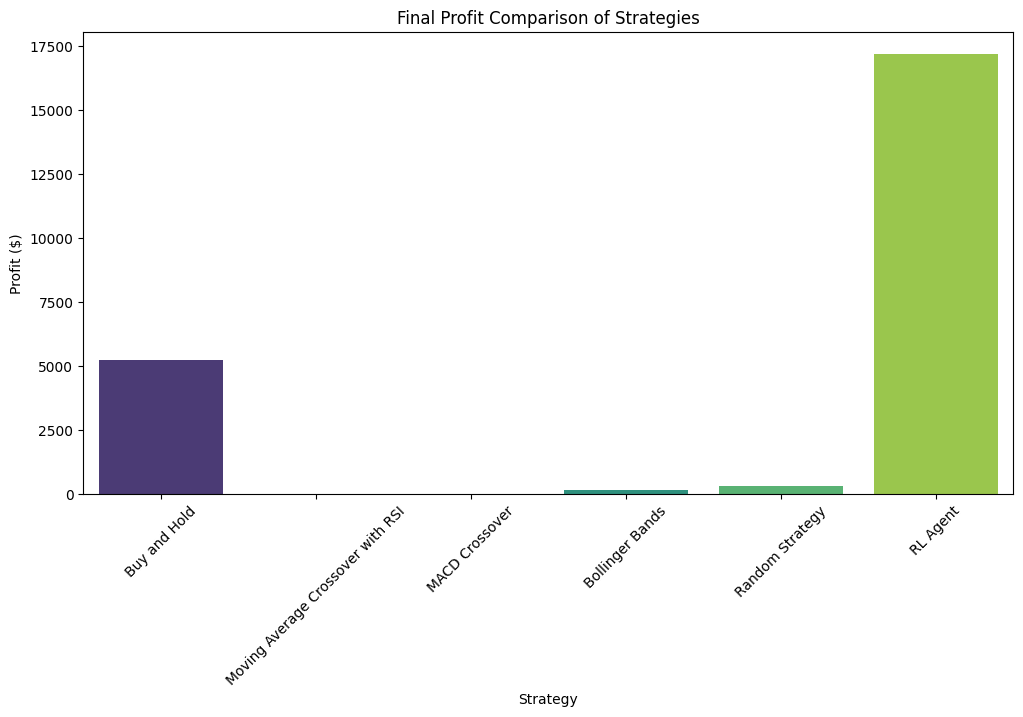

In [9]:


# Install necessary packages
!pip install stable-baselines3 gymnasium yfinance ta matplotlib seaborn

# Import libraries
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
import yfinance as yf
from ta import trend, momentum, volatility
import matplotlib.pyplot as plt
import seaborn as sns
from stable_baselines3 import DQN  # Using DQN
from stable_baselines3.common.env_checker import check_env
import warnings
from typing import Optional
import random

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# 1. Fetch and Prepare Data
def get_data(ticker: str, start_date: str, end_date: str) -> pd.DataFrame:
    """
    Downloads historical stock data and calculates technical indicators.

    Args:
        ticker (str): Stock ticker symbol.
        start_date (str): Start date for historical data (YYYY-MM-DD).
        end_date (str): End date for historical data (YYYY-MM-DD).

    Returns:
        pd.DataFrame: DataFrame containing stock prices and indicators.
    """
    # Download historical data
    df = yf.download(ticker, start=start_date, end=end_date)
    print(f"Downloaded data shape: {df.shape}")
    print(df.head())

    # Flatten MultiIndex columns if present
    if isinstance(df.columns, pd.MultiIndex):
        # Combine MultiIndex columns into single level by joining with an underscore
        df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df.columns.values]
        print("Flattened MultiIndex columns:")
        print(df.columns)

        # Remove ticker suffix if only one ticker
        suffixes = set(col.split('_')[-1] for col in df.columns)
        if len(suffixes) == 1:
            suffix = '_' + list(suffixes)[0]
            df.columns = [col.replace(suffix, '') for col in df.columns]
            print("Renamed columns by removing ticker suffix:")
            print(df.columns)

    # Calculate technical indicators
    sma10 = trend.SMAIndicator(close=df['Close'], window=10).sma_indicator()
    sma50 = trend.SMAIndicator(close=df['Close'], window=50).sma_indicator()
    rsi = momentum.RSIIndicator(close=df['Close'], window=14).rsi()
    macd = trend.MACD(close=df['Close']).macd()
    bollinger = volatility.BollingerBands(close=df['Close'], window=20, window_dev=2)
    bb_upper = bollinger.bollinger_hband()
    bb_lower = bollinger.bollinger_lband()

    # Assign indicators to DataFrame
    df['SMA10'] = sma10
    df['SMA50'] = sma50
    df['RSI'] = rsi
    df['MACD'] = macd
    df['BB_Upper'] = bb_upper
    df['BB_Lower'] = bb_lower

    # Handle any remaining NaN values using forward fill
    df.fillna(method='ffill', inplace=True)
    # Drop any remaining NaN values
    df.dropna(inplace=True)
    print(f"Final DataFrame shape after adding indicators: {df.shape}")
    print(df.head())

    # Reset index to have 'Date' as a column
    df.reset_index(inplace=True)

    return df

# 2. Create Custom Gymnasium Environment (Updated to Record Actions)
class StockTradingEnv(gym.Env):
    """
    A custom Gym environment for stock trading.
    """
    metadata = {'render.modes': ['human']}

    def __init__(self, df: pd.DataFrame, initial_balance: float = 10000, max_steps: Optional[int] = None):
        super(StockTradingEnv, self).__init__()

        self.df = df.copy().reset_index(drop=True)
        self.initial_balance = initial_balance
        self.current_step = 0
        self.max_steps = max_steps if max_steps else len(self.df) - 1

        # Define action space: 0 = Hold, 1 = Buy, 2 = Sell
        self.action_space = spaces.Discrete(3)

        # Define observation space: [Close, SMA10, SMA50, RSI, MACD, BB_Upper, BB_Lower, Holdings, Balance]
        low = np.array([0, 0, 0, 0, -np.inf, 0, 0, 0, 0], dtype=np.float32)
        high = np.array([np.inf, np.inf, np.inf, 100, np.inf, np.inf, np.inf, np.inf, np.inf], dtype=np.float32)
        self.observation_space = spaces.Box(low=low, high=high, dtype=np.float32)

        # Initialize state variables
        self.balance = initial_balance
        self.holdings = 0
        self.net_worth = initial_balance
        self.initial_balance = initial_balance

        # Track history for rendering and analysis
        self.history = []

    def _next_observation(self) -> np.ndarray:
        """
        Retrieves the next observation from the environment.

        Returns:
            np.ndarray: The current state observation.
        """
        obs = np.array([
            self.df.loc[self.current_step, 'Close'],
            self.df.loc[self.current_step, 'SMA10'],
            self.df.loc[self.current_step, 'SMA50'],
            self.df.loc[self.current_step, 'RSI'],
            self.df.loc[self.current_step, 'MACD'],
            self.df.loc[self.current_step, 'BB_Upper'],
            self.df.loc[self.current_step, 'BB_Lower'],
            float(self.holdings),
            float(self.balance)
        ], dtype=np.float32)  # Ensure dtype matches observation space
        return obs

    def step(self, action: int):
        """
        Executes an action in the environment.

        Args:
            action (int): The action to take (0=Hold, 1=Buy, 2=Sell).

        Returns:
            tuple: (observation, reward, terminated, truncated, info)
        """
        current_price = self.df.loc[self.current_step, 'Close']
        TRANSACTION_COST = 0.001  # 0.1% transaction cost

        # Execute action
        if action == 1:  # Buy
            total_cost = current_price * (1 + TRANSACTION_COST)
            if self.balance >= total_cost:
                self.holdings += 1
                self.balance -= total_cost
        elif action == 2:  # Sell
            if self.holdings > 0:
                total_revenue = current_price * (1 - TRANSACTION_COST)
                self.holdings -= 1
                self.balance += total_revenue
        # Action 0 is Hold; do nothing

        # Calculate net worth
        self.net_worth = self.balance + self.holdings * current_price

        # Reward is the change in net worth
        reward = self.net_worth - self.initial_balance

        # Update initial balance for the next step
        self.initial_balance = self.net_worth

        # Map action to string for clarity
        action_map = {0: 'Hold', 1: 'Buy', 2: 'Sell'}
        action_str = action_map.get(action, 'Hold')

        # Append to history
        self.history.append({
            'Step': self.current_step,
            'Date': self.df.loc[self.current_step, 'Date'],
            'Price': current_price,
            'Action': action_str,
            'Balance': self.balance,
            'Holdings': self.holdings,
            'Net Worth': self.net_worth,
            'Reward': reward
        })

        # Increment step
        self.current_step += 1
        done = self.current_step >= self.max_steps

        # Get next observation if not done
        if not done:
            obs = self._next_observation()
        else:
            obs = np.zeros(self.observation_space.shape, dtype=np.float32)

        # Termination condition
        terminated = done
        truncated = False

        return obs, reward, terminated, truncated, {}

    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None):
        """
        Resets the environment to an initial state.

        Returns:
            tuple: (initial_observation, info)
        """
        super().reset(seed=seed)
        self.balance = self.initial_balance
        self.holdings = 0
        self.net_worth = self.initial_balance
        self.current_step = 0
        self.history = []
        return self._next_observation(), {}

    def render(self, mode='human', close=False):
        """
        Renders the current state of the environment.

        Args:
            mode (str): The mode in which to render.
            close (bool): Whether to close the renderer.
        """
        profit = self.net_worth - self.initial_balance
        print(f'Step: {self.current_step}')
        print(f'Date: {self.df.loc[self.current_step, "Date"]}')
        print(f'Balance: ${self.balance:.2f}')
        print(f'Holdings: {self.holdings}')
        print(f'Net Worth: ${self.net_worth:.2f}')
        print(f'Profit: ${profit:.2f}')

# 3. Implement Baseline Strategies
def buy_and_hold(df: pd.DataFrame, initial_balance: float = 10000) -> dict:
    """
    Implements a Buy and Hold strategy.

    Args:
        df (pd.DataFrame): DataFrame containing stock prices.
        initial_balance (float): Starting balance.

    Returns:
        dict: Results of the strategy.
    """
    buy_price = df.iloc[0]['Close']
    holdings = initial_balance // buy_price
    balance = initial_balance - holdings * buy_price
    net_worth = balance + holdings * df.iloc[-1]['Close']
    profit = net_worth - initial_balance
    return {
        'Strategy': 'Buy and Hold',
        'Initial Balance': initial_balance,
        'Final Net Worth': net_worth,
        'Profit': profit
    }

def moving_average_crossover(df: pd.DataFrame, initial_balance: float = 10000) -> dict:
    """
    Implements a Moving Average Crossover strategy with RSI confirmation.

    Args:
        df (pd.DataFrame): DataFrame containing stock prices and indicators.
        initial_balance (float): Starting balance.

    Returns:
        dict: Results of the strategy.
    """
    balance = initial_balance
    holdings = 0
    net_worth = initial_balance

    for i in range(1, len(df)):
        # Golden cross with RSI < 30
        if df.loc[i-1, 'SMA10'] < df.loc[i-1, 'SMA50'] and df.loc[i, 'SMA10'] >= df.loc[i, 'SMA50']:
            if df.loc[i, 'RSI'] < 30:
                # Buy
                if balance >= df.loc[i, 'Close']:
                    holdings += 1
                    balance -= df.loc[i, 'Close']
        # Death cross with RSI > 70
        elif df.loc[i-1, 'SMA10'] > df.loc[i-1, 'SMA50'] and df.loc[i, 'SMA10'] <= df.loc[i, 'SMA50']:
            if df.loc[i, 'RSI'] > 70:
                # Sell
                if holdings > 0:
                    holdings -= 1
                    balance += df.loc[i, 'Close']
        net_worth = balance + holdings * df.loc[i, 'Close']

    profit = net_worth - initial_balance
    return {
        'Strategy': 'Moving Average Crossover with RSI',
        'Initial Balance': initial_balance,
        'Final Net Worth': net_worth,
        'Profit': profit
    }

def macd_strategy(df: pd.DataFrame, initial_balance: float = 10000) -> dict:
    """
    Implements a MACD strategy.

    Args:
        df (pd.DataFrame): DataFrame containing stock prices and MACD indicators.
        initial_balance (float): Starting balance.

    Returns:
        dict: Results of the strategy.
    """
    balance = initial_balance
    holdings = 0
    net_worth = initial_balance

    for i in range(1, len(df)):
        # MACD crossover
        if df.loc[i-1, 'MACD'] < 0 and df.loc[i, 'MACD'] >= 0:
            # Buy
            if balance >= df.loc[i, 'Close']:
                holdings += 1
                balance -= df.loc[i, 'Close']
        elif df.loc[i-1, 'MACD'] > 0 and df.loc[i, 'MACD'] <= 0:
            # Sell
            if holdings > 0:
                holdings -= 1
                balance += df.loc[i, 'Close']
        net_worth = balance + holdings * df.loc[i, 'Close']

    profit = net_worth - initial_balance
    return {
        'Strategy': 'MACD Crossover',
        'Initial Balance': initial_balance,
        'Final Net Worth': net_worth,
        'Profit': profit
    }

def bollinger_bands_strategy(df: pd.DataFrame, initial_balance: float = 10000) -> dict:
    """
    Implements a Bollinger Bands strategy.

    Args:
        df (pd.DataFrame): DataFrame containing stock prices and Bollinger Bands.
        initial_balance (float): Starting balance.

    Returns:
        dict: Results of the strategy.
    """
    balance = initial_balance
    holdings = 0
    net_worth = initial_balance

    for i in range(len(df)):
        # Buy when price crosses below lower band
        if df.loc[i, 'Close'] < df.loc[i, 'BB_Lower']:
            if balance >= df.loc[i, 'Close']:
                holdings += 1
                balance -= df.loc[i, 'Close']
        # Sell when price crosses above upper band
        elif df.loc[i, 'Close'] > df.loc[i, 'BB_Upper']:
            if holdings > 0:
                holdings -= 1
                balance += df.loc[i, 'Close']
        net_worth = balance + holdings * df.loc[i, 'Close']

    profit = net_worth - initial_balance
    return {
        'Strategy': 'Bollinger Bands',
        'Initial Balance': initial_balance,
        'Final Net Worth': net_worth,
        'Profit': profit
    }

def random_strategy(df: pd.DataFrame, initial_balance: float = 10000) -> dict:
    """
    Implements a Random strategy.

    Args:
        df (pd.DataFrame): DataFrame containing stock prices.
        initial_balance (float): Starting balance.

    Returns:
        dict: Results of the strategy.
    """
    balance = initial_balance
    holdings = 0
    net_worth = initial_balance

    for i in range(len(df)):
        action = random.choice(['Buy', 'Sell', 'Hold'])
        if action == 'Buy' and balance >= df.loc[i, 'Close']:
            holdings += 1
            balance -= df.loc[i, 'Close']
        elif action == 'Sell' and holdings > 0:
            holdings -= 1
            balance += df.loc[i, 'Close']
        net_worth = balance + holdings * df.loc[i, 'Close']

    profit = net_worth - initial_balance
    return {
        'Strategy': 'Random Strategy',
        'Initial Balance': initial_balance,
        'Final Net Worth': net_worth,
        'Profit': profit
    }

# 4. Training the RL Agent
def train_rl_agent(env: gym.Env, total_timesteps: int = 25000) -> DQN:
    """
    Trains a DQN agent on the provided environment.

    Args:
        env (gym.Env): The Gym environment.
        total_timesteps (int): Number of training timesteps.

    Returns:
        DQN: The trained DQN model.
    """
    model = DQN('MlpPolicy', env, verbose=1, device='cpu')
    model.learn(total_timesteps=total_timesteps)
    model.save("dqn_stock_trading")
    return model

# 5. Running the RL Agent
def run_rl_agent(env: gym.Env, model: DQN) -> list:
    """
    Runs the trained RL agent in the environment.

    Args:
        env (gym.Env): The Gym environment.
        model (DQN): The trained DQN model.

    Returns:
        list: History of actions and states.
    """
    obs, _ = env.reset()
    rl_history = []

    while True:
        action, _states = model.predict(obs, deterministic=True)
        # Ensure action is a scalar integer
        if isinstance(action, np.ndarray):
            try:
                action = int(action.item())
            except AttributeError:
                action = int(action[0])
        else:
            action = int(action)
        obs, reward, terminated, truncated, info = env.step(action)
        rl_history.append(env.history[-1])  # Store the latest step
        if terminated or truncated:
            break

    return rl_history

# 6. Performance Evaluation and Visualization
def visualize_actions(df: pd.DataFrame, rl_history: list):
    """
    Creates visualizations for the RL agent's actions.

    Args:
        df (pd.DataFrame): Original stock data.
        rl_history (list): History of actions and states from the RL agent.
    """
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Convert rl_history to DataFrame
    rl_df = pd.DataFrame(rl_history)

    # Ensure 'Date' is in datetime format
    rl_df['Date'] = pd.to_datetime(rl_df['Date'])

    # Display the first few rows to verify
    print("RL History Sample:")
    print(rl_df.head())

    # a. Create a Heatmap of Buy and Sell Actions
    # Filter only Buy and Sell actions
    actions_df = rl_df[rl_df['Action'].isin(['Buy', 'Sell'])].copy()

    if not actions_df.empty:
        # Set 'Date' as the index
        actions_df.set_index('Date', inplace=True)

        # Define the time bins (weekly)
        action_counts = actions_df.groupby([pd.Grouper(freq='W'), 'Action']).size().unstack(fill_value=0)

        if not action_counts.empty:
            # Plot the heatmap
            plt.figure(figsize=(20, 6))
            sns.heatmap(action_counts.T, cmap="YlGnBu", linewidths=.5, annot=True, fmt="d")
            plt.title('Weekly Buy and Sell Actions Heatmap')
            plt.xlabel('Week')
            plt.ylabel('Action')
            plt.show()
        else:
            print("No Buy or Sell actions to display in Heatmap.")
    else:
        print("No Buy or Sell actions to display in Heatmap.")

    # b. Overlay Buy and Sell Actions on the Stock Price Chart
    if not actions_df.empty:
        # Reset index to access 'Date' as a column
        actions_df.reset_index(inplace=True)

        # Create buy and sell signals
        buy_signals = actions_df[actions_df['Action'] == 'Buy']
        sell_signals = actions_df[actions_df['Action'] == 'Sell']

        plt.figure(figsize=(20, 10))
        plt.plot(df['Date'], df['Close'], label='Close Price', alpha=0.5)

        # Plot buy signals
        plt.scatter(buy_signals['Date'], buy_signals['Price'], marker='^', color='green', label='Buy', alpha=1)

        # Plot sell signals
        plt.scatter(sell_signals['Date'], sell_signals['Price'], marker='v', color='red', label='Sell', alpha=1)

        plt.title('Stock Price with Buy and Sell Signals')
        plt.xlabel('Date')
        plt.ylabel('Price ($)')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("No Buy or Sell actions to overlay on the price chart.")

    # c. (Optional) Create a 2D Heatmap Based on Time and Price Bins
    if not actions_df.empty:
        # Define price bins
        price_bins = np.linspace(df['Close'].min(), df['Close'].max(), 50)

        # Assign price bins to actions_df
        actions_df['Price_Bin'] = pd.cut(actions_df['Price'], bins=price_bins)

        # Define time bins (monthly)
        time_bins = pd.date_range(start=actions_df['Date'].min(), end=actions_df['Date'].max(), freq='M')
        actions_df['Time_Bin'] = pd.cut(actions_df['Date'], bins=time_bins)

        # Create pivot tables for Buy and Sell
        pivot_buy = actions_df[actions_df['Action'] == 'Buy'].groupby(['Time_Bin', 'Price_Bin']).size().unstack(fill_value=0)
        pivot_sell = actions_df[actions_df['Action'] == 'Sell'].groupby(['Time_Bin', 'Price_Bin']).size().unstack(fill_value=0)

        if not pivot_buy.empty:
            # Plot Buy Heatmap
            plt.figure(figsize=(20, 8))
            sns.heatmap(pivot_buy, cmap="Greens")
            plt.title('Buy Actions Density Heatmap')
            plt.xlabel('Price Bin')
            plt.ylabel('Time Bin')
            plt.show()
        else:
            print("No Buy actions to display in Buy Heatmap.")

        if not pivot_sell.empty:
            # Plot Sell Heatmap
            plt.figure(figsize=(20, 8))
            sns.heatmap(pivot_sell, cmap="Reds")
            plt.title('Sell Actions Density Heatmap')
            plt.xlabel('Price Bin')
            plt.ylabel('Time Bin')
            plt.show()
        else:
            print("No Sell actions to display in Sell Heatmap.")
    else:
        print("No Buy or Sell actions to display in 2D Heatmaps.")

    # d. Print Detailed Results
    rl_final_net_worth = rl_df.iloc[-1]['Net Worth'] if not rl_df.empty else 0
    rl_profit = rl_final_net_worth - 10000
    bh_result = buy_and_hold(df, initial_balance=10000)
    ma_result = moving_average_crossover(df, initial_balance=10000)
    macd_result = macd_strategy(df, initial_balance=10000)
    bb_result = bollinger_bands_strategy(df, initial_balance=10000)
    random_result = random_strategy(df, initial_balance=10000)

    strategies = [bh_result, ma_result, macd_result, bb_result, random_result]
    rl_result = {
        'Strategy': 'RL Agent',
        'Initial Balance': 10000,
        'Final Net Worth': rl_final_net_worth,
        'Profit': rl_profit
    }
    strategies.append(rl_result)

    print("\nStrategy Performance:")
    for result in strategies:
        print(f"{result['Strategy']}:")
        print(f"  Initial Balance: ${result['Initial Balance']}")
        print(f"  Final Net Worth: ${result['Final Net Worth']:.2f}")
        print(f"  Profit: ${result['Profit']:.2f}\n")

    # Plotting the final profits
    profit_data = {
        strategy['Strategy']: strategy['Profit']
        for strategy in strategies
    }

    plt.figure(figsize=(12,6))
    sns.barplot(x=list(profit_data.keys()), y=list(profit_data.values()), palette="viridis")
    plt.title('Final Profit Comparison of Strategies')
    plt.xlabel('Strategy')
    plt.ylabel('Profit ($)')
    plt.xticks(rotation=45)
    plt.show()

# 7. Main Execution
if __name__ == "__main__":
    # Parameters
    TICKER = 'BODALCHEM.NS'  # Bodalchem on NSE
    START_DATE = '2020-01-01'
    END_DATE = '2023-01-01'
    INITIAL_BALANCE = 10000
    TOTAL_TIMESTEPS = 25000  # Reduced to 25k as per request

    # 1. Fetch data
    print("Fetching data...")
    df = get_data(TICKER, START_DATE, END_DATE)

    # 2. Initialize environment
    print("\nInitializing environment...")
    env = StockTradingEnv(df, initial_balance=INITIAL_BALANCE)

    # 3. Check environment compatibility
    print("\nChecking environment compatibility...")
    try:
        check_env(env, warn=True)
    except AssertionError as e:
        print(f"Environment check failed: {e}")
        print("Ensure that your environment inherits from gymnasium.Env and follows the Gymnasium API.")
    except TypeError as e:
        print(f"Environment reset method error: {e}")
        print("Ensure that the reset() method accepts 'seed' and 'options' parameters.")

    # 4. Train RL Agent
    print("\nTraining RL Agent...")
    rl_model = train_rl_agent(env, total_timesteps=TOTAL_TIMESTEPS)

    # 5. Run RL Agent
    print("\nRunning RL Agent...")
    rl_history = run_rl_agent(env, rl_model)

    # 6. Run Baseline Strategies
    print("\nRunning Baseline Strategies...")
    bh_result = buy_and_hold(df, initial_balance=INITIAL_BALANCE)
    ma_result = moving_average_crossover(df, initial_balance=INITIAL_BALANCE)
    macd_result = macd_strategy(df, initial_balance=INITIAL_BALANCE)
    bb_result = bollinger_bands_strategy(df, initial_balance=INITIAL_BALANCE)
    random_result = random_strategy(df, initial_balance=INITIAL_BALANCE)

    # 7. Compile and Visualize Results
    print("\nCompiling and Visualizing Results...")
    visualize_actions(df, rl_history)